In [1]:
import utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c, h, k_B, M_sun, L_sun
from matplotlib.patches import Rectangle
from tqdm import tqdm
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
from lmfit import Model, Parameters
from itertools import compress, zip_longest, combinations, chain
from scipy.stats import cumfreq
utils.rcparams()

In [2]:
herschel = utils.full_loader('Herschel')
vla = utils.full_loader('VLA_COSMOS2020_05')

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

#### Functions

In [3]:
def bb(nu, t):
    return (nu**3)*(1/(np.exp((h.value*nu)/(k_B.value*t)) - 1))


def mbb(nu_rest, log_norm, t, beta):
    norm = 10**log_norm
    return norm*(nu_rest**beta)*bb(nu_rest, t)

# Create a set of N random sources
def random_sources(n, ra_min, ra_max, dec_min, dec_max):
    sources_rand = []
    for it in range(n):
        ra_random, dec_random = np.random.uniform(ra_min, ra_max), np.random.uniform(dec_min, dec_max)
        random_source = Source(it, ra_random, dec_random, np.array([0]), np.array([0]), np.array([0]))
        sources_rand.append(random_source)
    return sources_rand


def create_sources_and_counterparts(source_params, counterpart_params):

    source_catalogue = []
    for obj in tqdm(range(len(source_params['data'])), desc='Creating Sources'):
        name = source_params['data'][source_params['name']][obj]
        ra = source_params['data'][source_params['ra']][obj]
        dec = source_params['data'][source_params['dec']][obj]
        wavelengths_obs_um = source_params['wavelengths_obs_um']
        fluxes = np.array(source_params['data'][source_params['fluxes']].iloc[obj])
        flux_errors = np.array(source_params['data'][source_params['flux_errors']].iloc[obj])
        source = Source(name, ra, dec, wavelengths_obs_um, fluxes, flux_errors)
        source_catalogue.append(source)

    counterpart_catalogue = []
    for obj in tqdm(range(len(counterpart_params['data'])), desc='Creating Counterparts'):
        name = counterpart_params['data'][counterpart_params['name']][obj]
        ra = counterpart_params['data'][counterpart_params['ra']][obj]
        dec = counterpart_params['data'][counterpart_params['dec']][obj]
        fluxes = np.array(counterpart_params['data'][counterpart_params['fluxes']].iloc[obj])
        redshift = counterpart_params['data'][counterpart_params['redshift']][obj]
        stellar_mass = counterpart_params['data'][counterpart_params['stellar_mass']][obj]
        counterpart = Counterpart(name, ra, dec, fluxes, redshift, stellar_mass)
        counterpart_catalogue.append(counterpart)

    return source_catalogue, counterpart_catalogue

In [ ]:
def get_s_values(self, r_max, n=10000, random_sources=False):
        if random_sources:
            sources = self.get_random_sources(n)
        else:
            sources = self.sources

        min_s_values = []
        for source in tqdm(sources, desc='Calculating S Values'):
            counterpart_s_values = []
            for counterpart in self.counterparts:
                r = counterpart.separation(source)
                if r <= r_max:
                    s = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    counterpart_s_values.append(s)
            min_s = min(counterpart_s_values, default=np.nan)
            min_s_values.append(min_s)
        N = len(sources)
        return min_s_values, N

In [350]:
class Survey2:

    def __init__(self, sources, counterparts):

        # Input sources and counterparts
        self.sources_all = sources
        self.counterparts_all = counterparts
        print('Input Number of Sources = {}'.format(len(self.sources_all)))
        print('Input Number of Counterparts = {}'.format(len(self.counterparts_all)))

        # Define the overlapping survey area
        sources_ra = [self.sources_all[obj].ra for obj in range(len(self.sources_all))]
        sources_dec = [self.sources_all[obj].dec for obj in range(len(self.sources_all))]
        counterparts_ra = [self.counterparts_all[obj].ra for obj in range(len(self.counterparts_all))]
        counterparts_dec = [self.counterparts_all[obj].dec for obj in range(len(self.counterparts_all))]
        self.ra_min, self.ra_max = max(min(sources_ra),min(counterparts_ra)), min(max(sources_ra),max(counterparts_ra))
        self.dec_min, self.dec_max = max(min(sources_dec),min(counterparts_dec)), min(max(sources_dec),max(counterparts_dec))
        self.area_deg = (abs(self.ra_max - self.ra_min)) * (abs(self.dec_max - self.dec_min))
        self.area_arcsec = (np.sqrt(self.area_deg)*3600)**2

        # Reduce sources and counterparts to overlapping region
        self.sources = [obj for obj in self.sources_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        self.counterparts = [obj for obj in self.counterparts_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        print('Overlapping Number of Sources = {} ({:.2f}%)'.format(len(self.sources), (len(self.sources)/len(self.sources_all))*100))
        print('Overlapping Number of Counterparts = {} ({:.2f}%)'.format(len(self.counterparts), (len(self.counterparts)/len(self.counterparts_all))*100))

    # Get random sources
    def get_random_sources(self, n):
        sources_rand = random_sources(n, self.ra_min, self.ra_max, self.dec_min, self.dec_max)
        return sources_rand

    def get_s_values(self, r_max_arcsec, n=100000, random=False):
        if random:
            sources = self.get_random_sources(n)
        else:
            sources = self.sources

        min_s_values = []
        for source in tqdm(sources, desc = 'Calculating S Values'):
            counterpart_s_values = []
            r_max_deg = r_max_arcsec/3600
            ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
            possible_counterparts = [counterpart for counterpart in self.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
            for counterpart in possible_counterparts:
                r = counterpart.separation(source)
                if r <= r_max:
                    s = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    counterpart_s_values.append(s)
            min_s = min(counterpart_s_values, default=np.nan)
            min_s_values.append(min_s)
        min_s_values_finite = np.array([s for s in min_s_values if np.isfinite(s)])
        min_s_values_finite_sorted = sorted(min_s_values_finite)
        return min_s_values_finite_sorted

    def get_matches(self, r_max_arcsec, n=100000):
        d_s_random = self.get_s_values(r_max_arcsec=r_max_arcsec, n=n, random=True)
        pairs = []
        for source in tqdm(self.sources, desc='Calculating P Values'):
            r_max_deg = r_max_arcsec/3600
            ra_min, ra_max, dec_min, dec_max = source.ra-r_max_deg, source.ra+r_max_deg, source.dec-r_max_deg, source.dec+r_max_deg
            possible_counterparts = [counterpart for counterpart in self.counterparts if (ra_min < counterpart.ra < ra_max) & (dec_min < counterpart.dec < dec_max)]
            for counterpart in possible_counterparts:
                r = counterpart.separation(source)
                if r <= r_max:
                    s_i = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    p = len([s for s in d_s_random if s < s_i])/n
                    if p < 1/n:
                        p = 1/n
                    pair = Pair(source, counterpart, r, s_i, p)
                    pairs.append(pair)
        return d_s_random, pairs


In [351]:
cosmos2 = Survey2(herschel_objects, vla_objects)

Input Number of Sources = 11185
Input Number of Counterparts = 10830
Overlapping Number of Sources = 7230 (64.64%)
Overlapping Number of Counterparts = 10826 (99.96%)


In [363]:
d_s_random, pairs = cosmos2.get_matches(r_max_arcsec=10, n=50000)

Calculating P Values: 100%|██████████| 7230/7230 [00:47<00:00, 152.68it/s]


In [364]:
d_s_herschel = cosmos2.get_s_values(r_max_arcsec=10)

Calculating S Values: 100%|██████████| 7230/7230 [00:27<00:00, 259.61it/s]


In [366]:
len(d_s_random)/50000

0.09238

In [367]:
max([pair.p for pair in pairs])

0.09232

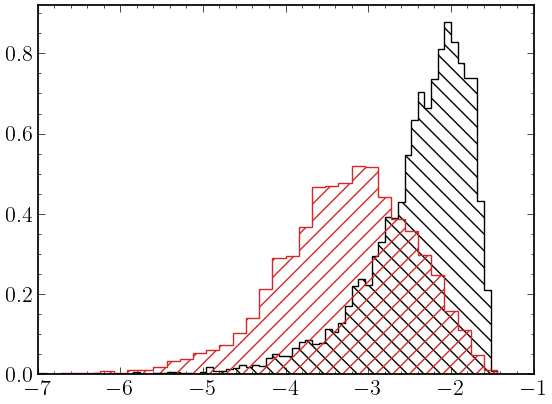

In [368]:
fig, ax = plt.subplots()
ax.hist(np.log10(d_s_random), bins=100, range=(-8,0), histtype='step', hatch=r'\\', density=True)
ax.hist(np.log10(d_s_herschel), bins=50, range=(-8,0), histtype='step', hatch=r'//', density=True)
ax.set_xlim(-7,-1)
plt.show()

In [369]:
[pair.p for pair in pairs]

[2e-05,
 0.0006,
 0.0402,
 0.00046,
 0.00038,
 0.00108,
 0.00096,
 0.00022,
 0.00082,
 0.00368,
 0.00062,
 0.00098,
 6e-05,
 0.00066,
 0.0002,
 0.00022,
 0.00206,
 0.07408,
 0.02196,
 0.00334,
 0.06846,
 0.00744,
 0.00776,
 0.00976,
 0.06868,
 0.0206,
 0.00438,
 0.01902,
 0.00184,
 0.062,
 0.00012,
 0.00394,
 0.03136,
 2e-05,
 0.001,
 0.00026,
 0.00044,
 0.00036,
 0.02722,
 0.00106,
 0.0007,
 0.00026,
 0.0002,
 0.0277,
 0.00142,
 0.00196,
 0.00062,
 0.00924,
 0.00786,
 0.00158,
 0.0002,
 0.00172,
 0.00316,
 0.00606,
 0.00506,
 0.00018,
 0.00082,
 0.00022,
 0.00018,
 0.00164,
 0.00384,
 0.07476,
 0.00206,
 0.00194,
 0.0704,
 0.00426,
 2e-05,
 0.00172,
 0.00452,
 0.07022,
 0.00252,
 0.01038,
 0.0245,
 0.00476,
 0.065,
 0.00448,
 0.00316,
 0.00324,
 0.022,
 0.00164,
 0.00096,
 0.00124,
 0.00022,
 0.00082,
 2e-05,
 0.0002,
 0.00092,
 0.00066,
 0.02886,
 0.00022,
 0.00308,
 0.0303,
 0.00034,
 0.07684,
 0.00104,
 0.00024,
 0.00228,
 0.01126,
 0.0241,
 0.00554,
 0.00088,
 0.05192,
 0.0001,
 0

In [373]:
[pair.p for pair in herschel_vla]

[0.0001,
 0.0006000000000000001,
 0.030699999999999998,
 0.0004500000000000001,
 0.0004000000000000001,
 0.0009500000000000001,
 0.0009000000000000001,
 0.00030000000000000003,
 0.0009000000000000001,
 0.0032,
 0.00075,
 0.0009000000000000001,
 0.0002,
 0.00075,
 0.00025,
 0.00030000000000000003,
 0.0018000000000000004,
 0.06075,
 0.018799999999999997,
 0.0029000000000000002,
 0.054349999999999996,
 0.00685,
 0.00685,
 0.0091,
 0.054349999999999996,
 0.0165,
 0.0036,
 0.0165,
 0.0015000000000000002,
 0.0486,
 0.0002,
 0.0032,
 0.02735,
 0.0001,
 0.0009000000000000001,
 0.0004000000000000001,
 0.0004500000000000001,
 0.0004000000000000001,
 0.024149999999999998,
 0.0009500000000000001,
 0.0008500000000000001,
 0.0004000000000000001,
 0.00025,
 0.024149999999999998,
 0.0013000000000000002,
 0.0018000000000000004,
 0.00075,
 0.0091,
 0.008,
 0.0013000000000000002,
 0.00025,
 0.0015000000000000002,
 0.0029000000000000002,
 0.005149999999999999,
 0.004399999999999999,
 0.0002,
 0.0009000000

In [4]:
class Object:

    def __init__(self, name, ra_deg, dec_deg):
        self.id = name
        self.ra = ra_deg
        self.dec = dec_deg


class Source(Object):

    def __init__(self, name, ra, dec, wavelengths_obs_um, fluxes, flux_errors):
        Object.__init__(self, name=name, ra_deg=ra, dec_deg=dec)
        self.wavelengths_obs_um = wavelengths_obs_um
        self.fluxes = fluxes
        self.flux_errors = flux_errors


class Counterpart(Object):

    def __init__(self, name, ra, dec, fluxes, redshift, stellar_mass):
        Object.__init__(self, name=name, ra_deg=ra, dec_deg=dec)
        self.fluxes = fluxes
        self.redshift = redshift
        self.stellar_mass = stellar_mass

    @property
    def luminosity_distance(self):
        return cosmo.luminosity_distance(z = self.redshift)

    def number_density(self, counterparts, area):
        return np.sum([counterpart.fluxes > self.fluxes for counterpart in counterparts])/area

    def separation(self, other):
        return np.sqrt(((self.ra - other.ra)**2)+((self.dec - other.dec)**2))*3600

    def s_value(self, source, counterparts, area):
        r = self.separation(source)
        n = self.number_density(counterparts, area)
        s = (r**2)*n
        return s


class Pair:

    def __init__(self, source, counterpart, r, s, p, fit_sed=True):
        self.source = source
        self.counterpart = counterpart
        self.r = r
        self.s = s
        self.p = p

        self.t_cmb = 2.725*(1+self.counterpart.redshift)
        self.source.wavelengths_obs_m = self.source.wavelengths_obs_um*1e-6
        self.source.wavelengths_rest_m = self.source.wavelengths_obs_m/(1+self.counterpart.redshift)
        self.source.nu_rest = c.value/self.source.wavelengths_rest_m

        if fit_sed:

            if np.isnan(self.counterpart.redshift):
                self.log_norm = np.nan
                self.t = np.nan
                self.beta = np.nan
            else:
                mbb_model = Model(mbb)
                params = Parameters()
                params.add_many(('log_norm', -60, True, -65, -55),
                                ('t', 20, True, self.t_cmb, 50),
                                ('beta', 2, True, 1, 4))
                mbb_fit = mbb_model.fit(self.source.fluxes, params, nu_rest=self.source.nu_rest, weights=1/self.source.flux_errors)

                self.log_norm = mbb_fit.params['log_norm'].value
                self.t = mbb_fit.params['t'].value
                self.beta = mbb_fit.params['beta'].value

    def sed(self, nu_rest):
        return mbb(nu_rest, self.log_norm, self.t, self.beta)*u.Jy

    def fir_luminosity(self, lam_um_rest_low=8, lam_um_rest_high=1000):
        lam_low_um_rest, lam_high_um_rest = lam_um_rest_low*u.micron, lam_um_rest_high*u.micron
        wave_range_rest_um = np.linspace(1, 5000, 100000) * u.micron
        wave_range_rest_m = wave_range_rest_um.to(u.m)
        freq_range_rest = c / wave_range_rest_m
        idx = np.where((wave_range_rest_um >= lam_low_um_rest) & (wave_range_rest_um <= lam_high_um_rest))

        diff_freq = np.diff(freq_range_rest)
        diff_freq = np.append(diff_freq, diff_freq[-1])

        sed_obs_integral = self.sed(freq_range_rest[idx].value)
        sed_rest_integral = sed_obs_integral/(1+self.counterpart.redshift)
        integral = np.sum(-sed_rest_integral*diff_freq[idx])

        d_L = cosmo.luminosity_distance(z=self.counterpart.redshift).to(u.m)
        l_watt = (4 * np.pi * (d_L ** 2) * integral).to(u.Watt)
        l_sun = l_watt.to(u.L_sun)
        return l_sun

    def sfr(self):
        # From Murphy+2011
        l_sun = self.fir_luminosity()
        l_cgs = l_sun.to(u.erg/u.s)
        constant = 3.88e-44*(u.M_sun/u.yr)/(u.erg/u.s)
        sfr = constant*l_cgs
        return sfr


class Survey:

    def __init__(self, sources, counterparts):

        # Input sources and counterparts
        self.sources_all = sources
        self.counterparts_all = counterparts
        print('Input Number of Sources = {}'.format(len(self.sources_all)))
        print('Input Number of Counterparts = {}'.format(len(self.counterparts_all)))

        # Define the overlapping survey area
        sources_ra = [self.sources_all[obj].ra for obj in range(len(self.sources_all))]
        sources_dec = [self.sources_all[obj].dec for obj in range(len(self.sources_all))]
        counterparts_ra = [self.counterparts_all[obj].ra for obj in range(len(self.counterparts_all))]
        counterparts_dec = [self.counterparts_all[obj].dec for obj in range(len(self.counterparts_all))]
        self.ra_min, self.ra_max = max(min(sources_ra),min(counterparts_ra)), min(max(sources_ra),max(counterparts_ra))
        self.dec_min, self.dec_max = max(min(sources_dec),min(counterparts_dec)), min(max(sources_dec),max(counterparts_dec))
        self.area_deg = (abs(self.ra_max - self.ra_min)) * (abs(self.dec_max - self.dec_min))
        self.area_arcsec = (np.sqrt(self.area_deg)*3600)**2

        # Reduce sources and counterparts to overlapping region
        self.sources = [obj for obj in self.sources_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        self.counterparts = [obj for obj in self.counterparts_all if (obj.ra > self.ra_min) & (obj.ra < self.ra_max) & (obj.dec > self.dec_min) & (obj.dec < self.dec_max)]
        print('Overlapping Number of Sources = {} ({:.2f}%)'.format(len(self.sources), (len(self.sources)/len(self.sources_all))*100))
        print('Overlapping Number of Counterparts = {} ({:.2f}%)'.format(len(self.counterparts), (len(self.counterparts)/len(self.counterparts_all))*100))

    # Get random sources
    def get_random_sources(self, n):
        sources_rand = random_sources(n, self.ra_min, self.ra_max, self.dec_min, self.dec_max)
        return sources_rand

    def get_s_values(self, r_max, n=10000, random_sources=False):
        if random_sources:
            sources = self.get_random_sources(n)
        else:
            sources = self.sources

        min_s_values = []
        for source in tqdm(sources, desc='Calculating S Values'):
            counterpart_s_values = []
            for counterpart in self.counterparts:
                r = counterpart.separation(source)
                if r <= r_max:
                    s = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    counterpart_s_values.append(s)
            min_s = min(counterpart_s_values, default=np.nan)
            min_s_values.append(min_s)
        N = len(sources)
        return min_s_values, N

    # Get S distribution
    def get_s_dist(self, r_max, n=10000, n_bins=100, random_sources=False):
        min_s_values, N = self.get_s_values(r_max, n, random_sources)
        min_s_values_finite = np.array([s for s in min_s_values if np.isfinite(s)])
        s_hist, bin_edges = np.histogram(min_s_values_finite, bins=np.logspace(-8,0,n_bins))
        s_hist_norm = s_hist/N
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2

        s_distribution = {'N': N,
                          'dist': s_hist,
                          'dist_norm': s_hist_norm,
                          'bin_edges': bin_edges,
                          'bin_centers': bin_centers,
                          'S_values': min_s_values}

        return s_distribution

    # Get IDs
    def get_matches(self, r_max, n=10000, n_bins=100):
        s_distribution_random = self.get_s_dist(r_max, n, n_bins, random_sources=True)

        pairs = []
        for source in tqdm(self.sources, desc='Calculating P Values'):
            for counterpart in self.counterparts:
                r = counterpart.separation(source)
                if r <= r_max:
                    s = counterpart.s_value(source, self.counterparts, self.area_arcsec)
                    s_idx = np.argmin(abs(s-s_distribution_random['bin_centers']))
                    p = np.trapz(s_distribution_random['dist_norm'][:s_idx])
                    if p < 1/s_distribution_random['N']:
                        p = 1/s_distribution_random['N']
                    pair = Pair(source, counterpart, r, s, p)
                    pairs.append(pair)

        return pairs


class Group:

    def __init__(self, pairs):
        self.pairs = pairs

    def counterpart_counterpart_z_difference(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        z_diff = [abs(self.pairs[it[0]].counterpart.redshift - self.pairs[it[1]].counterpart.redshift) for it in index_list]
        return z_diff

    def select_close_counterpart_pairs(self, z_max=0.2):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        z_diff = self.counterpart_counterpart_z_difference()
        close_index = [idx for idx, z in zip(index_list, z_diff) if z <= z_max]
        close_index_flat = list(set([item for sublist in close_index for item in sublist]))
        close_pairs = [self.pairs[idx] for idx in close_index_flat]
        return close_pairs

    def counterpart_source_separations(self):
        separations_arcsec = [pair.r for pair in self.pairs]
        return separations_arcsec

    def counterpart_counterpart_separations(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        separations_arcsec = [self.pairs[it[0]].counterpart.separation(self.pairs[it[1]].counterpart) for it in index_list]
        return separations_arcsec

    def counterpart_counterpart_distance(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        av_z = [(self.pairs[it[0]].counterpart.redshift+self.pairs[it[1]].counterpart.redshift)/2 for it in index_list]
        separations_arcsec = self.counterpart_counterpart_separations()*u.arcsec
        try:
            d_A = cosmo.angular_diameter_distance(av_z)
        except:
            d_A = np.nan*u.Mpc

        distance_kpc = (separations_arcsec*d_A).to(u.kpc, u.dimensionless_angles())
        return distance_kpc

    def counterpart_counterpart_flux_difference(self):
        obj_list = list(range(len(self.pairs)))
        index_list = list(combinations(obj_list,2))
        flux1 = [self.pairs[it[0]].counterpart.fluxes.item() for it in index_list]
        flux2 = [self.pairs[it[1]].counterpart.fluxes.item() for it in index_list]
        max_fluxes = np.array(list(map(max, zip(flux1, flux2))))
        min_fluxes = np.array(list(map(min, zip(flux1, flux2))))
        ratio = min_fluxes/max_fluxes
        return ratio



#### Create Survey

In [5]:
source_params = {'data': herschel,
                 'name': 'id_her',
                 'ra': 'RA_her',
                 'dec': 'Dec_her',
                 'wavelengths_obs_um': np.array([250,350,500]),
                 'fluxes': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500'],
                 'flux_errors': ['F_BLIND_MF_SPIRE_250', 'F_BLIND_MF_SPIRE_350', 'F_BLIND_MF_SPIRE_500']}

counterpart_params = {'data': vla,
                      'name': 'id_cos',
                      'ra': 'RA_cos',
                      'dec': 'Dec_cos',
                      'fluxes': ['total_int_flux'],
                      'redshift': 'lp_zPDF',
                      'stellar_mass': 'lp_mass_med'}


In [6]:
herschel_objects, vla_objects = create_sources_and_counterparts(source_params, counterpart_params)

Creating Counterparts: 100%|██████████| 10830/10830 [00:01<00:00, 9961.06it/s]


In [7]:
cosmos = Survey(herschel_objects, vla_objects)

print('The overlapping region covers RA: {:.2f} - {:.2f} and Dec {:.2f} - {:.2f}'.format(cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max))
print('The total area of the overlapping region = {:.2f} square degrees'.format(cosmos.area_deg))

Input Number of Sources = 11185
Input Number of Counterparts = 10830
Overlapping Number of Sources = 7230 (64.64%)
Overlapping Number of Counterparts = 10826 (99.96%)
The overlapping region covers RA: 149.29 - 150.95 and Dec 1.45 - 3.04
The total area of the overlapping region = 2.64 square degrees


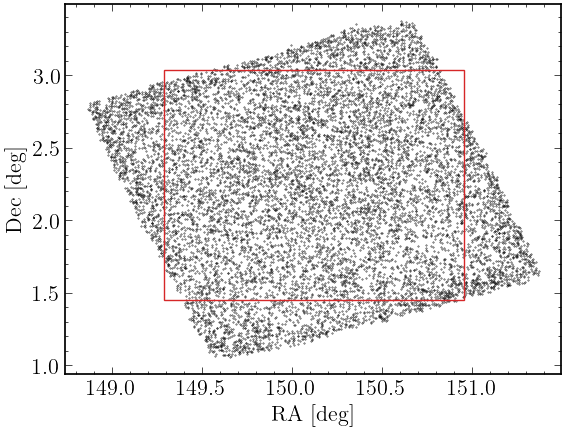

In [8]:
herschel_ras = [herschel_objects[it].ra for it in range(len(herschel_objects))]
herschel_decs = [herschel_objects[it].dec for it in range(len(herschel_objects))]

fig, ax = plt.subplots()
ax.scatter(herschel_ras, herschel_decs, s=0.1)
ax.add_patch(Rectangle((cosmos.ra_min, cosmos.dec_min), cosmos.ra_max-cosmos.ra_min, cosmos.dec_max-cosmos.dec_min, edgecolor='tab:red', facecolor='none'))
ax.set_xlabel(r'RA [deg]')
ax.set_ylabel(r'Dec [deg]')
plt.savefig(utils.ROOT+'/figures/sky_map.pdf', dpi=1000)
plt.show()

In [104]:
print('The surface density of radio sources = {:.0f} [per square degree]'.format(len(cosmos.counterparts)/cosmos.area_deg))

The surface density of radio sources = 4103 [per square degree]


### Optimal Search Radius

In [14]:
herschel_vla_large_r = cosmos.get_matches(30)

Calculating P Values: 100%|██████████| 7230/7230 [02:12<00:00, 54.67it/s]


In [19]:
sc_offset_large_r = [pair.r for pair in herschel_vla_large_r]

In [96]:
r_range = np.linspace(0, 30, 100)
total_r = cumfreq(sc_offset_large_r, numbins=len(r_range), defaultreallimits=(min(r_range), max(r_range)))
total_r_per_source = total_r.cumcount/len(herschel_objects)

N = 1000
rand_sources = random_sources(N, cosmos.ra_min, cosmos.ra_max, cosmos.dec_min, cosmos.dec_max)

rand_r_values = []
for source in tqdm(rand_sources, desc='Offsets from Random Sources'):
    for counterpart in vla_objects:
        r_val = counterpart.separation(source)
        if r_val <= max(r_range):
            rand_r_values.append(r_val)

background_r = cumfreq(rand_r_values, numbins=len(r_range), defaultreallimits=(min(r_range), max(r_range)))
background_r_per_source = background_r.cumcount/N

true_r_per_source = total_r_per_source-background_r_per_source

Offsets from Random Sources: 100%|██████████| 1000/1000 [00:36<00:00, 27.24it/s]


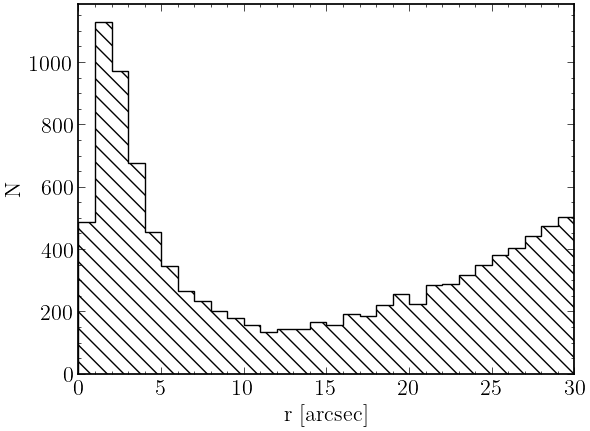

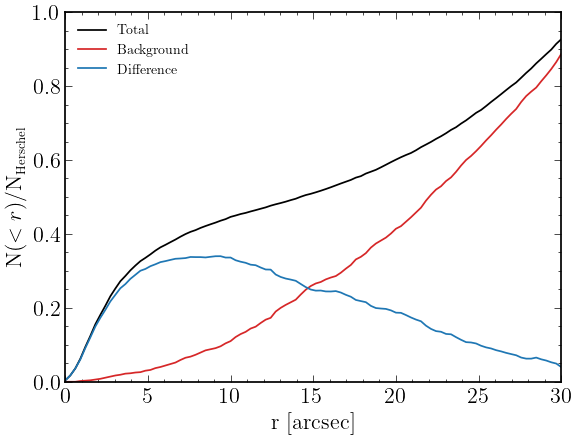

In [105]:
fig, ax = plt.subplots()
ax.hist(sc_offset_large_r, bins=30, range=(0,30), histtype='step', hatch=r'\\')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.set_xlim(0,30)
plt.show()

fig, ax = plt.subplots()
ax.plot(r_range, total_r_per_source, label=r'Total')
ax.plot(r_range, background_r_per_source, label='Background')
ax.plot(r_range, true_r_per_source, label='Difference')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N($< r$)/N$_{\small \textrm{Herschel}}$')
ax.set_xlim(0,30)
ax.set_ylim(0,1)
ax.legend(fontsize=10)
plt.show()

In [106]:
r_max_cumulative = r_range[np.argmax(true_r_per_source)]
print('The radius at which we have the highest expected difference between total number of counterparts and background counterparts = {:.2f} arcsec'.format(r_max_cumulative))

The radius at which we have the highest expected difference between total number of counterparts and background counterparts = 9.39 arcsec


#### D(S) Distributions

In [390]:
r_max = 10
herschel_ds, N_herschel = cosmos.get_s_values(r_max)
random_ds, N_random = cosmos.get_s_values(r_max, n=50000, random_sources=True)

Calculating S Values: 100%|██████████| 50000/50000 [05:44<00:00, 145.31it/s]


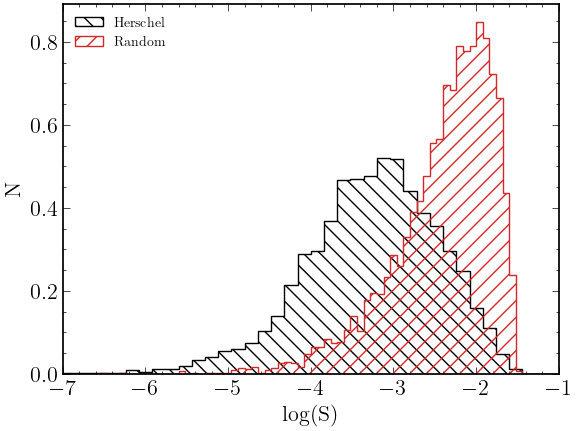

In [391]:
n_bins_herschel = 50
n_bins_random = 100
logs_range = (-8,0)

fig, ax = plt.subplots()
ax.hist(np.log10(herschel_ds), bins=n_bins_herschel, range=logs_range, histtype='step', hatch=r'\\', label=r'Herschel', density=True)
ax.hist(np.log10(random_ds), bins=n_bins_random, range=logs_range, histtype='step', hatch=r'//', label=r'Random', density=True)
ax.set_xlabel(r'log(S)')
ax.set_ylabel(r'N')
ax.set_xlim(-7,-1)
ax.legend(fontsize=10, loc='upper left')
plt.show()

#### Creating Robust Groups

In [10]:
r_max = 10
herschel_vla = cosmos.get_matches(r_max)

Calculating P Values: 100%|██████████| 7230/7230 [01:40<00:00, 71.89it/s]


In [11]:
p_max = 0.05
robust_idx = [herschel_vla[it].p < p_max for it in range(len(herschel_vla))]
herschel_vla_robust = list(compress(herschel_vla, robust_idx))

In [12]:
herschel_vla_robust_ids, herschel_vla_robust_counts = np.unique([herschel_vla_robust[it].source.id for it in range(len(herschel_vla_robust))], return_counts=True)
herschel_vla_robust_sorted = sorted(herschel_vla_robust, key = lambda x: (x.source.id, x.p))
herschel_vla_robust_lists = [[val for i, val in enumerate(herschel_vla_robust_sorted) if val.source.id == idx] for idx in herschel_vla_robust_ids]
herschel_vla_robust_array = np.array(list(zip_longest(*herschel_vla_robust_lists, fillvalue=np.nan))).T
herschel_vla_robust_singles = herschel_vla_robust_array[pd.isna(herschel_vla_robust_array[:, 1])][:,0]
herschel_vla_robust_multiples = herschel_vla_robust_array[~pd.isna(herschel_vla_robust_array[:, 1])]

In [13]:
herschel_vla_robust_singles_list = [[pair] for pair in herschel_vla_robust_singles]
herschel_vla_robust_multiples_list = [herschel_vla_robust_multiples[it][~pd.isnull(herschel_vla_robust_multiples[it])].tolist() for it in range(len(herschel_vla_robust_multiples))]

robust_singles = [Group(pairs) for pairs in herschel_vla_robust_singles_list]
robust_multiples = [Group(pairs) for pairs in herschel_vla_robust_multiples_list]
robust_all = robust_singles+robust_multiples

#### Important Statistics

Here include statistics about the expected maximum P, ID fraction and expected false ID rate.

In [121]:
D_s = cosmos.get_s_dist(10, n=5000, n_bins=50, random_sources=True)

Calculating S Values: 100%|██████████| 5000/5000 [00:41<00:00, 119.50it/s]


In [122]:
np.sum(D_s['dist_norm'])

0.08940000000000001

In [375]:
len(cosmos.sources)

7230

In [387]:
sources_30mjy = [obj for obj in cosmos.sources if obj.fluxes[0] > 0.03]
robust_all_30mjy = [obj for obj in robust_all if obj.pairs[0].source.fluxes[0] > 0.03]

In [388]:
len(sources_30mjy)

1324

In [389]:
len(robust_all_30mjy)

1063

In [377]:
print('The number of sources with robust radio IDs = {} ({:.2f}%)'.format(len(robust_all), (len(robust_all)/len(cosmos.sources))*100))

The number of sources with robust radio IDs = 3954 (54.69%)


In [390]:
print('The number of sources > 30mJy with robust radio IDs = {} ({:.2f}%)'.format(len(robust_all_30mjy), (len(robust_all_30mjy)/len(sources_30mjy))*100))

The number of sources > 30mJy with robust radio IDs = 1063 (80.29%)


In [409]:
p_singles = [obj.pairs[0].p for obj in robust_singles]

print('Expected false ID rate of robust IDs = {:.2f} ({:.2f}%)'.format(np.sum(p_singles), (np.sum(p_singles)/len(robust_singles))*100))

Expected false ID rate of robust IDs = 41.42 (1.20%)


In [408]:
p_singles

[0.0001,
 0.0004500000000000001,
 0.0004000000000000001,
 0.0009500000000000001,
 0.0009000000000000001,
 0.00030000000000000003,
 0.0009000000000000001,
 0.0009000000000000001,
 0.0002,
 0.00075,
 0.00025,
 0.00030000000000000003,
 0.0018000000000000004,
 0.0091,
 0.0002,
 0.0001,
 0.0009000000000000001,
 0.0004000000000000001,
 0.0004500000000000001,
 0.0009500000000000001,
 0.0008500000000000001,
 0.0004000000000000001,
 0.00025,
 0.0018000000000000004,
 0.00075,
 0.0013000000000000002,
 0.00025,
 0.0015000000000000002,
 0.0029000000000000002,
 0.005149999999999999,
 0.004399999999999999,
 0.0002,
 0.0009000000000000001,
 0.00035000000000000005,
 0.0002,
 0.0015000000000000002,
 0.0032,
 0.0018000000000000004,
 0.0018000000000000004,
 0.0032,
 0.0001,
 0.0015000000000000002,
 0.0036,
 0.0036,
 0.0036,
 0.0029000000000000002,
 0.0029000000000000002,
 0.018799999999999997,
 0.0015000000000000002,
 0.0009000000000000001,
 0.0011,
 0.00030000000000000003,
 0.0009000000000000001,
 0.0001

#### ID Fraction

In [213]:
herschel_flux_all = [obj.fluxes[0] for obj in cosmos.sources]
robust_flux_all = [obj.pairs[0].source.fluxes[0] for obj in robust_all]
robust_flux_single = [obj.pairs[0].source.fluxes[0] for obj in robust_singles]
robust_flux_multiple = [obj.pairs[0].source.fluxes[0] for obj in robust_multiples]

In [214]:
flux_range = np.logspace(-2.5, 0, 30)

robust_flux_all_id = np.histogram(robust_flux_all, bins=flux_range)[0]/np.histogram(herschel_flux_all, bins=flux_range)[0]
robust_flux_single_id = np.histogram(robust_flux_single, bins=flux_range)[0]/np.histogram(herschel_flux_all, bins=flux_range)[0]
robust_flux_multiple_id = np.histogram(robust_flux_multiple, bins=flux_range)[0]/np.histogram(herschel_flux_all, bins=flux_range)[0]

/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_19433/2091524045.py:3: RuntimeWarning: invalid value encountered in divide
  robust_flux_all_id = np.histogram(robust_flux_all, bins=flux_range)[0]/np.histogram(herschel_flux_all, bins=flux_range)[0]
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_19433/2091524045.py:4: RuntimeWarning: invalid value encountered in divide
  robust_flux_single_id = np.histogram(robust_flux_single, bins=flux_range)[0]/np.histogram(herschel_flux_all, bins=flux_range)[0]
/var/folders/ns/qp23v8156kgbxx0rc9nsr4bm0000gn/T/ipykernel_19433/2091524045.py:5: RuntimeWarning: invalid value encountered in divide
  robust_flux_multiple_id = np.histogram(robust_flux_multiple, bins=flux_range)[0]/np.histogram(herschel_flux_all, bins=flux_range)[0]


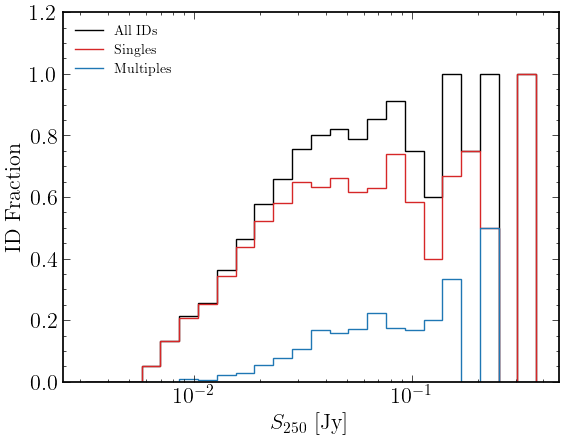

In [215]:
fig, ax = plt.subplots()
ax.stairs(robust_flux_all_id, flux_range, label=r'All IDs')
ax.stairs(robust_flux_single_id, flux_range, label=r'Singles')
ax.stairs(robust_flux_multiple_id, flux_range, label=r'Multiples')
ax.set_xlabel(r'$S_{250}$ [Jy]')
ax.set_ylabel(r'ID Fraction')
ax.set_ylim(0,1.2)
ax.semilogx()
ax.legend(loc='upper left', fontsize=10)
plt.show()

#### Source-Counterpart Offsets

In [229]:
robust_all_sc_offset = list(chain.from_iterable([obj.counterpart_source_separations() for obj in robust_all]))
robust_singles_sc_offset = list(chain.from_iterable([obj.counterpart_source_separations() for obj in robust_singles]))
robust_multiples_sc_offset = list(chain.from_iterable([obj.counterpart_source_separations() for obj in robust_multiples]))

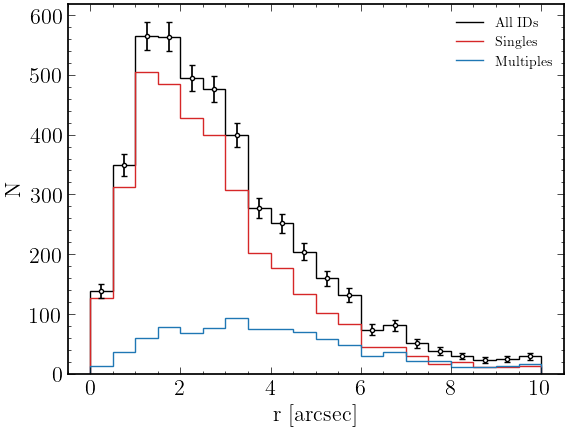

In [232]:
all_sc_hist, r_bins = np.histogram(robust_all_sc_offset, bins=20, range=(0,10))
single_sc_hist, _ = np.histogram(robust_singles_sc_offset, bins=20, range=(0,10))
multiple_sc_hist, _ = np.histogram(robust_multiples_sc_offset, bins=20, range=(0,10))
r_bin_centers = (r_bins[:-1] + r_bins[1:])/2

fig, ax = plt.subplots()
ax.stairs(all_sc_hist, r_bins, label='All IDs')
ax.errorbar(r_bin_centers, all_sc_hist, yerr=np.sqrt(all_sc_hist), fmt='.', c='k')
ax.stairs(single_sc_hist, r_bins, label='Singles')
ax.stairs(multiple_sc_hist, r_bins, label='Multiples')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.legend(fontsize=10)
plt.show()

#### Counterpart-Counterpart Redshift Differences

In [3]:
robust_multiples_cc_zdiff = list(chain.from_iterable([obj.counterpart_counterpart_z_difference() for obj in robust_multiples]))

NameError: name 'chain' is not defined

In [243]:
n_z_bins = 20
n_z_bins_random = 100
z_range = (0,4)

N = 1000000
random_z_differences = []

for _ in range(N):
    rand_obj_1, rand_obj_2 = random.sample(vla_objects, 2)
    rand_z_diff = abs(rand_obj_1.redshift - rand_obj_2.redshift)
    if rand_z_diff > 0:
        random_z_differences.append(rand_z_diff)

weights_z = np.full_like(random_z_differences, (n_z_bins_random/n_z_bins)*(len(robust_multiples_cc_zdiff)/N))

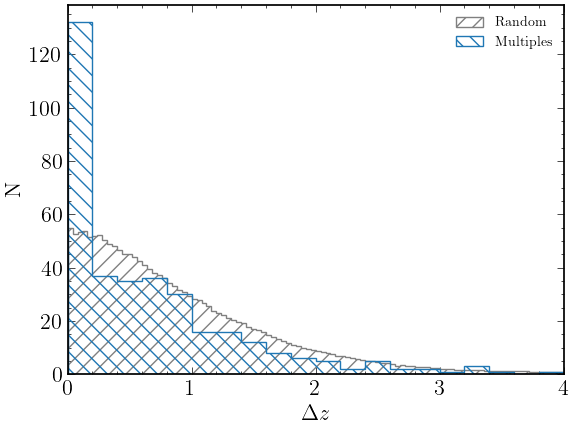

In [255]:
fi, ax = plt.subplots()
ax.hist(random_z_differences, bins=n_z_bins_random, range=z_range, histtype='step', hatch=r'//', color='grey', label=r'Random', weights=weights_z)
ax.hist(robust_multiples_cc_zdiff, bins=n_z_bins, range=z_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Multiples')
ax.set_xlabel(r'$\Delta z$')
ax.set_ylabel(r'N')
ax.set_xlim(0,4)
ax.legend(fontsize=10)
plt.show()

In [355]:
robust_close_multiples_list = [robust_multiples[it].select_close_counterpart_pairs(z_max=0.2) for it in range(len(robust_multiples))]
robust_close_multiples = [Group(pairs) for pairs in robust_close_multiples_list]

#### Counterpart-Counterpart Offsets

In [325]:
robust_multiples_cc_offsets = list(chain.from_iterable([obj.counterpart_counterpart_separations() for obj in robust_multiples]))
robust_close_multiples_cc_offsets = list(chain.from_iterable([obj.counterpart_counterpart_separations() for obj in robust_close_multiples]))

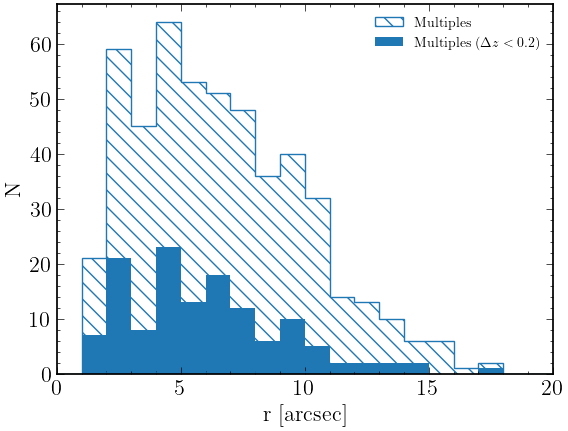

In [326]:
n_bins = 20
r_range = (0,20)

fig, ax = plt.subplots()
ax.hist(robust_multiples_cc_offsets, bins=n_bins, range=r_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Multiples')
ax.hist(robust_close_multiples_cc_offsets, bins=n_bins, range=r_range, histtype='stepfilled', color='tab:blue', label=r'Multiples ($\Delta z < 0.2$)')
ax.set_xlabel(r'r [arcsec]')
ax.set_ylabel(r'N')
ax.set_xlim(0,20)
ax.legend(fontsize=10)
plt.show()

In [327]:
robust_close_multiples_cc_distance = list(chain.from_iterable([obj.counterpart_counterpart_distance() for obj in robust_close_multiples]))

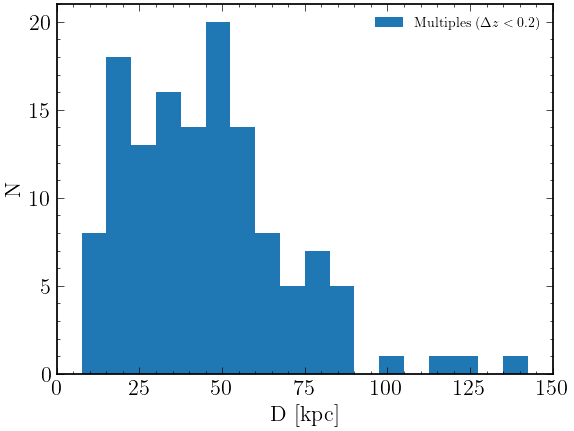

In [328]:
n_bins = 20
d_range = (0,150)

fig, ax = plt.subplots()
ax.hist(robust_close_multiples_cc_distance, bins=n_bins, range=d_range, histtype='stepfilled', color='tab:blue', label=r'Multiples ($\Delta z < 0.2$)')
ax.set_xlabel(r'D [kpc]')
ax.set_ylabel(r'N')
ax.set_xlim(0,150)
ax.legend(fontsize=10)
plt.show()

#### Counterpart-Counterpart Flux Differences

In [329]:
robust_multiples_cc_fdiff = list(chain.from_iterable([obj.counterpart_counterpart_flux_difference() for obj in robust_multiples]))
robust_close_multiples_cc_fdiff = list(chain.from_iterable([obj.counterpart_counterpart_flux_difference() for obj in robust_close_multiples]))

In [333]:
n_f_bins = 10
n_f_bins_random = 100
logf_range = (0,1)

N = 1000000
random_f_differences = []

for _ in range(N):
    rand_obj_1, rand_obj_2 = random.sample(vla_objects, 2)
    rand_flux_diff = abs(rand_obj_1.fluxes.item() - rand_obj_2.fluxes.item())
    if rand_flux_diff > 0:
        random_f_differences.append(rand_flux_diff)

weights_f = np.full_like(random_f_differences, (n_f_bins_random/n_f_bins)*(len(robust_multiples_cc_fdiff)/N))

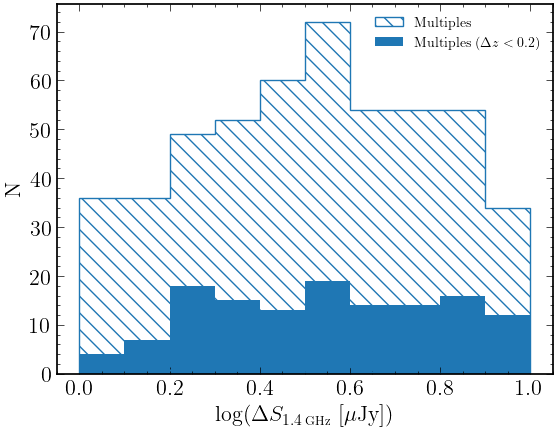

In [334]:
fig, ax = plt.subplots()
#ax.hist(np.log10(random_f_differences), bins=n_f_bins_random, range=logf_range, histtype='step', hatch=r'//', color='grey', label=r'Random', weights=weights_f)
ax.hist(robust_multiples_cc_fdiff, bins=n_f_bins, range=logf_range, histtype='step', hatch=r'\\', color='tab:blue', label=r'Multiples')
ax.hist(robust_close_multiples_cc_fdiff, bins=n_f_bins, range=logf_range, histtype='stepfilled', color='tab:blue', label=r'Multiples ($\Delta z < 0.2$)')
ax.set_xlabel(r'log($\Delta S_{\small 1.4\,\textrm{GHz}}$ [$\mu$Jy])')
ax.set_ylabel(r'N')
ax.legend(fontsize=10)
plt.show()

#### Galaxy Main Sequence

In [44]:
def scoville_ms(logm_star, z):
    a = (0.59*logm_star)-5.77
    b = (0.22*logm_star)+0.59
    return (10**a)*((1+z)**b)

def scoville_ssfr(logm_star, z):
    ssfr_yr = (scoville_ms(logm_star, z)/(10**logm_star))/u.yr
    return ssfr_yr.to(1/u.Gyr)

def sfr_from_ssfr(logm_star, formation_time_gyr=1, fraction_of_hubble=None):
    m_star = (10**logm_star)*u.M_sun
    if fraction_of_hubble is not None:
        formation_time = fraction_of_hubble*cosmo.hubble_time
    else:
        formation_time = formation_time_gyr*u.Gyr
    ssfr = 1/formation_time
    sfr = m_star*ssfr
    return (sfr).to(u.M_sun/u.yr).value

def ssfr_from_sfr(logm_star, sfr):
    m_star = (10**logm_star)*u.M_sun
    sfr = sfr*(u.Msun/u.yr)
    ssfr = sfr/m_star
    return ssfr.to(1/u.Gyr)

In [45]:
robust_singles_00z05 = [obj for obj in robust_singles if 0 < obj.pairs[0].counterpart.redshift < 0.5]
robust_singles_05z10 = [obj for obj in robust_singles if 0.5 < obj.pairs[0].counterpart.redshift < 1]
robust_singles_10z15 = [obj for obj in robust_singles if 1 < obj.pairs[0].counterpart.redshift < 1.5]
robust_singles_15z20 = [obj for obj in robust_singles if 1.5 < obj.pairs[0].counterpart.redshift < 2]
robust_singles_20z25 = [obj for obj in robust_singles if 2 < obj.pairs[0].counterpart.redshift < 2.5]
robust_singles_25z30 = [obj for obj in robust_singles if 2.5 < obj.pairs[0].counterpart.redshift < 3]

In [46]:
logm_range = np.linspace(8.5,12.5,1000)
scoville_slice = [scoville_ssfr(logm_range, z=0.25), scoville_ssfr(logm_range, z=0.75), scoville_ssfr(logm_range, z=1.25), scoville_ssfr(logm_range, z=1.75), scoville_ssfr(logm_range, z=2.25), scoville_ssfr(logm_range, z=2.75)]

In [47]:
robust_singles_all = [robust_singles_00z05,robust_singles_05z10,robust_singles_10z15,robust_singles_15z20,robust_singles_20z25,robust_singles_25z30]

In [1]:
z_slice = [r'$0 < z < 0.5$', r'$0.5 < z < 1$', r'$1 < z < 1.5$', r'$1.5 < z < 2$', r'$2 < z < 2.5$', r'$2.5 < z < 3$']

fig, ((ax1, ax2, ax3), (ax4, ax5,ax6)) = plt.subplots(2,3,sharex=True,sharey=True)
axes = [ax1,ax2,ax3,ax4,ax5,ax6]
for idx,ax in enumerate(axes):
    sfrs = np.array([obj.pairs[0].sfr().value for obj in robust_singles_all[idx]])
    masses = np.array([obj.pairs[0].counterpart.stellar_mass for obj in robust_singles_all[idx]])
    ssfrs = ssfr_from_sfr(masses, sfrs)
    ax.scatter(masses, ssfrs, s=0.1)
    ax.plot(logm_range, scoville_slice[idx], c='r')
    ax.plot(logm_range, ssfr_from_sfr(logm_range, 1), 'k-')
    ax.plot(logm_range, ssfr_from_sfr(logm_range, 10), 'k--')
    ax.plot(logm_range, ssfr_from_sfr(logm_range, 100), 'k:')
    ax.text(0.4, 0.85, z_slice[idx], fontsize=12, transform=ax.transAxes)
ax1.semilogy()
ax1.set_xlim(8.5,12.5)
ax1.set_ylim(5e-3, 5e2)
ax6.text(0.05, 0.1, 'Scoville+2014', fontsize=8, color='r', transform=ax.transAxes)
plt.subplots_adjust(hspace=0, wspace=0)
fig.supxlabel(r'log($M_{*}$ [$M_{\odot}$])', y=-0.025)
fig.supylabel(r'sSFR [Gyr$^{-1}$]', x=-0.01)
plt.show()

NameError: name 'plt' is not defined

#### ML Properties